## Supplementary data and code for Sims-Williams, (2022).*Token frequency as a determinant of morphological change*.

This notebook runs through each step of the model presented in Sims-Williams (2022), reproducing figures, tables and statistics found there. References (in text fields and comments) are to numbered sections of the paper.

In [1]:
from lepage_py3 import find_x # Importing the analogy-solving algorithm described in section 2.2.1.
import pandas as pd
import numpy as np
import scipy.stats  as stats
import itertools
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Well-formedness tests passed
Ill-formedness tests passed


## Loading data (2.1.1 – 2.1.2)
The synchronic and diachronic data can be found in the following files:

* *synchronic_data.csv*   (see section 2.1.1)
* *diachronic_data.csv*   (see section 2.1.2)

In [2]:
synchronic_data = pd.read_csv('synchronic_data.csv').set_index('cell').transpose()
diachronic_data = pd.read_csv('diachronic_data.csv').set_index(['class','cell']).sort_index()

In [3]:
synchronic_data # See Table 3 in the print version for full forms. In this representation, the symbol <X> represents any phonological sequence that remains constant over all values of person and number.

cell,strong aorist,weak aorist,perfect,kappatic aorist,root aorist
1sg,Xon,Xa,Xa,Xka,Xn
2sg,Xes,Xas,Xas,Xkas,Xs
3sg,Xe,Xe,Xe,Xke,X
1pl,Xomen,Xamen,Xamen,Xmen,Xmen
2pl,Xete,Xate,Xate,Xte,Xte
3pl,Xon,Xan,Xa:si,Xsan,Xsan


In [4]:
diachronic_data # See section 2.1.2 for full details. In this representation, the symbol <X> represents any phonological sequence that remains constant over all values of person and number.

form
class           cell        
kappatic aorist 1pl   Xkamen
                1pl   Xsamen
                1sg      Xsa
                2pl    Xkate
                2pl    Xsate
                2sg     Xkes
                2sg     Xsas
                3pl     Xkan
                3pl   Xka:si
                3sg      Xse
perfect         3pl      Xan
strong aorist   1pl    Xamen
                1sg       Xa
                2pl     Xate
                2sg      Xas
                3pl      Xan
                3pl    Xa:si
                3pl    Xosan
weak aorist     2pl     Xete
                2sg      Xes
                3pl    Xa:si
                3pl    Xasan

## Defining analogical proportions (2.2.2)
This code defines a proportion as a function of a base and target cell, and a source and destination inflection class. If possible, an analogical projection for part *x* of the proportion will be generated. This form is then checked for phonological acceptability and whether it is present in either the synchronic or the diachronic data (see 2.2.2 for details).

In [5]:
class Proportion(object):
    def __init__(self, base_cell, target_cell, source_class, destination_class):
        self.base = base_cell
        self.target = target_cell
        self.source = source_class
        self.destination = destination_class
        self.a = synchronic_data.at[base_cell,source_class]
        self.b = synchronic_data.at[target_cell,source_class]
        self.c = synchronic_data.at[base_cell,destination_class]
        self.d = synchronic_data.at[target_cell,destination_class] # Synchronically correct form        
        self.viability = None # Will contain viability score assigned by logistic regression model
    @property
    def attested_diachronically(self):
        """Returns True if x is attested in the diachronic data, False otherwise."""
        try: 
            changes = diachronic_data.loc[(self.destination,self.target),'form'] # Diachronic records for target cell and destination class.
            return (self.x in list(changes))
        except (KeyError, TypeError): return False # No record in diachronic data for given target cell and destination class, or no form could be generated for x
    @property    
    def x(self):
        """Generates an analogical form for x, if possible. If the proportion can't be solved, x will have the value None"""
        try: return find_x(self.a, self.b, self.c)
        except ValueError: return None # No analogical form could be generated, because the proportion is ill-formed
    @property
    def holds_synchronically(self): 
        """Returns True iff the analogical form generated by proportion is already present in the synchronic data."""
        return self.x == self.d 
    @property
    def phonologically_acceptable(self):
        """Returns True iff x is acceptable according to phonotactic constraints of Greek"""
        word = self.x
        if word == None: return None # No analogical form was generated
        for seq in ["ns", "aa", "ea", "nm", "n:", "oa", "oe", "ae", "ee", "mk"]: # Forbidden phonological sequences
            if seq in word: return False
        if word == 'X': return True # If the form is just a bare stem, next line will raise IndexError.
        final_segment, penultimate_segment = word[-1], word[-2]
        if final_segment not in ['a', 'e', 'i', 'o', 'u', 'n', 's','r', ':', 'X']: return False # Permitted final segments. ':' represents a long vowel, and 'X' represents segments which are invariant across all aorist active cells (roughly equivalent to the aorist active stem)
        if final_segment in ['n', 's', 'r'] and penultimate_segment not in ['X', 'a', 'e', 'i', 'o', 'u', ':']: return False # No final consonant clusters allowed.
        return True
    def __str__(self): return "%s (%s) : %s (%s) = %s : %s (%s -> %s)" % (self.a, self.base, self.b, self.target, self.c, self.x, self.source, self.destination)

## Comparing hypothetical proportions to the diachronic data (3.1)
Now we create a set of valid proportions, given the synchronic data as a starting point, and check which of them generate forms that are found in the diachronic data (see section 2.2.2, Table 8)

In [6]:
cells = ['1sg', '2sg', '3sg', '1pl', '2pl', '3pl']
classes = ['strong aorist','weak aorist','perfect','kappatic aorist','root aorist']
# Generating list of 600 possible proportions
proportions = [Proportion(base_cell,target_cell,source_class,destination_class) for (base_cell,target_cell,source_class,destination_class) in itertools.product(cells, cells, classes, classes) if base_cell != target_cell and source_class != destination_class]
# Valid proportions (those which generate a phonologically acceptable prediction for x which is not in the synchronic data).
valid = [p for p in proportions if p.x != None and p.phonologically_acceptable and not p.holds_synchronically]
# Valid proportions which generate a form that is attested in the diachronic data.
attested = [p for p in valid if p.attested_diachronically]

Generating Table 9 (3.1), summarising the numbers of valid & successful proportions generated by the model, and the number of hypothetical and actual innovative forms these correspond to.

In [7]:
# Summary table (Table 9) showing how many valid proportions and forms are created by the model, vs those which are actually attested in the diachronic data.
proportions_totals = {
    'Proportions': [len(valid), len(attested)],
    'Forms': [len(set([(p.x, p.target, p.destination) for p in valid])), len(set([(p.x, p.target, p.destination) for p in attested]))]
}
pd.DataFrame(proportions_totals, index=['Valid','Attested'])

,Proportions,Forms
Valid,249,106
Attested,64,22


Generating the data shown in Table 10 (3.1), showing likelihood of each combination of values for person and number appearing in the base and target of a successful proportion.

In [8]:
summary = { # How many times each cell appears in the base and target of valid proportions vs proportions that generate diachronically attested forms.
    'potential base': np.array([float(len([p for p in proportions if p in valid and p.base == cell])) for cell in cells]),
    'actual base': np.array([float(len([p for p in proportions if p in attested and p.base == cell])) for cell in cells]),
    'potential target':  np.array([float(len([p for p in proportions if p in valid and p.target == cell])) for cell in cells]),
    'actual target':  np.array([float(len([p for p in proportions if p in attested and p.target == cell])) for cell in cells]),}
# Probabilities that a proportion generates a diachronically attested form, given the cell in the base or target
summary['P(x is attested diachronically|base cell)'] = (summary['actual base']/summary['potential base'])
summary['P(x is attested diachronically|target cell)'] = (summary['actual target']/summary['potential target'])

cell_likelihoods = pd.DataFrame(summary, index=cells)
cell_likelihoods.index.name = 'cell'
cell_likelihoods

,potential base,actual base,potential target,actual target,P(x is attested diachronically|base cell),P(x is attested diachronically|target cell)
cell,,,,,,
1sg,22.0,9.0,59.0,4.0,0.409091,0.067797
2sg,40.0,12.0,35.0,8.0,0.300000,0.228571
3sg,53.0,26.0,29.0,1.0,0.490566,0.034483
1pl,54.0,7.0,33.0,11.0,0.129630,0.333333
2pl,52.0,4.0,28.0,13.0,0.076923,0.464286
3pl,28.0,6.0,65.0,27.0,0.214286,0.415385


## Correlation with relative frequency (3.2)
Now we load the frequency data (from the file cell_frequency.csv), and measure the correlation between a cell's relative frequency, and the probability that a proportion generates a diachronically attested form, given the cells appearing in its base and target. The corpus on which these figures are based is explained in section 2.3.

In [9]:
# Loading relative frequencies of each cell (see section 2.3, Figures 2-5) in a sample of 9 Attic authors available in the Perseus corpus.
frequencies = pd.read_csv('cell_frequency.csv').set_index('Cell').transpose()
frequencies

Cell,Aeschylus,Euripides,Sophocles,Aristophanes,dramatists,Xenophon,historians,Demosthenes,Lysias,orators,Plato,Aristotle,philosophers,all authors
1sg,0.241078,0.291613,0.306620,0.285995,0.287317,0.149604,0.149604,0.197598,0.231907,0.203683,0.184074,0.028041,0.140042,0.182824
2sg,0.234214,0.230808,0.256845,0.224256,0.234574,0.104336,0.104336,0.098711,0.067877,0.093242,0.181004,0.129852,0.166569,0.153830
3sg,0.395251,0.331537,0.326531,0.325569,0.335699,0.462557,0.462557,0.461078,0.374935,0.445799,0.439080,0.596541,0.483515,0.443220
1pl,0.031573,0.054369,0.030937,0.055512,0.047246,0.037100,0.037100,0.032528,0.028682,0.031846,0.094357,0.046748,0.080922,0.056395
2pl,0.027702,0.025416,0.025292,0.044991,0.031925,0.020944,0.020944,0.079675,0.092481,0.081946,0.009722,0.002059,0.007559,0.028950
3pl,0.070181,0.066258,0.053774,0.063678,0.063239,0.225458,0.225458,0.130410,0.204118,0.143483,0.091763,0.196757,0.121392,0.134781


In [10]:
frequency = frequencies['Aristophanes'] # We will use frequency statistics from Aristophanes.

Obtaining correlation coefficients & p-values between cell frequency, and likelihood of appearing in the base or target of a successful proportion (that generates a diachronically attested form). These figures are cited in section 3.2 and Figures 6-7.


In [11]:
correlations = {
    'base likelihood & cell frequency': stats.pearsonr(frequency, cell_likelihoods['P(x is attested diachronically|base cell)']),
    'target likelihood & cell frequency': stats.pearsonr(frequency, cell_likelihoods['P(x is attested diachronically|target cell)'])
}
pd.DataFrame(correlations, index=["r", 'p-value'])


,base likelihood & cell frequency,target likelihood & cell frequency
r,0.96335,-0.965213
p-value,0.00199,0.001794


Plotting the correlations to generate Figures 6-7 (section 3.2)

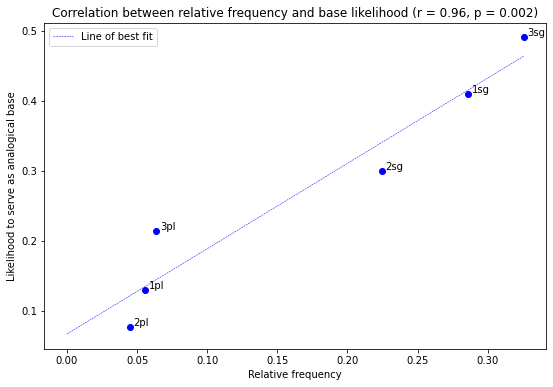

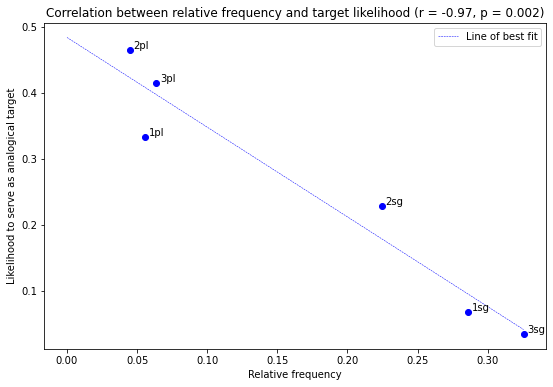

In [12]:
# Plotting the correlations
figures = []
for w in ['base', 'target']:
    fig, ax = plt.subplots(figsize=(9,6))
    ax.set_xlabel('Relative frequency')
    ax.set_ylabel('Likelihood to serve as analogical %s' % w)
    ax.set_title('Correlation between relative frequency and %s likelihood (r = %.2f, p = %.3f)' % (w, correlations['%s likelihood & cell frequency' % w][0], correlations['%s likelihood & cell frequency' % w][1]))
    x, y = frequency, cell_likelihoods['P(x is attested diachronically|%s cell)' % w]
    ax.scatter(x, y, c='b')
    for i in range(6): ax.annotate(cells[i], (x[i] + 0.0025, y[i] + 0.0025))
    slope, intercept = np.polyfit(x, y, 1)
    bounds = np.array([0,max(x)])
    ax.plot(bounds, slope*bounds + intercept, 'b--', lw=0.5,label='Line of best fit')
    ax.legend(loc='best')
    figures.append(fig)

## Logistic regression model (4.1)
Developing a logistic regression model to predict whether x is attested diachronically, from the relative frequency of the base and target cells of a proportion (the proportion's **viability score**). The logistic regression data is generated in the cell below, and is also given in full in the file *regression_data.csv*.

In [13]:
# Creating logistic regression data
regression_data = {
    'Base_frequency': [frequency.at[p.base] for p in valid],
    'Target_frequency': [frequency.at[p.target] for p in valid],
    'x_attested_diachronically': [1 if p.attested_diachronically else 0 for p in valid]
}
regression_table = pd.DataFrame(regression_data, index=[str(p) for p in valid])
regression_table

,Base_frequency,Target_frequency,x_attested_diachronically
Xn (1sg) : Xs (2sg) = Xon : Xos (root aorist -> strong aorist),0.285995,0.224256,0
Xn (1sg) : X (3sg) = Xon : Xo (root aorist -> strong aorist),0.285995,0.325569,0
Xa (1sg) : Xamen (1pl) = Xka : Xkamen (weak aorist -> kappatic aorist),0.285995,0.055512,1
Xa (1sg) : Xamen (1pl) = Xka : Xkamen (perfect -> kappatic aorist),0.285995,0.055512,1
Xn (1sg) : Xmen (1pl) = Xka : Xmeka (root aorist -> kappatic aorist),0.285995,0.055512,0
...,...,...,...
Xan (3pl) : Xamen (1pl) = Xsan : Xsamen (weak aorist -> kappatic aorist),0.063678,0.055512,1
Xan (3pl) : Xamen (1pl) = Xsan : Xsamen (weak aorist -> root aorist),0.063678,0.055512,0
Xan (3pl) : Xate (2pl) = Xon : Xote (weak aorist -> strong aorist),0.063678,0.044991,0
Xan (3pl) : Xate (2pl) = Xsan : Xsate (weak aorist -> kappatic aorist),0.063678,0.044991,1


Fitting the logistic regression model and displaying a summary of the results, as shown in Table 11 (4.1).

In [14]:
# Fitting logistic regression model
model = smf.logit("x_attested_diachronically ~ Base_frequency + Target_frequency", data=regression_table)
result = model.fit(method='newton')
result.summary()

Optimization terminated successfully.
         Current function value: 0.466822
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     x_attested_diachronically   No. Observations:                  249
Model:                                 Logit   Df Residuals:                      246
Method:                                  MLE   Df Model:                            2
Date:                       Mon, 01 Nov 2021   Pseudo R-squ.:                  0.1809
Time:                               11:37:25   Log-Likelihood:                -116.24
converged:                              True   LL-Null:                       -141.91
Covariance Type:                   nonrobust   LLR p-value:                 7.088e-12
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.0535      0.403     -2.615      0.009      -1.843      -0.264
Base_frequency       5.4371      1.403      3.876      0.000       2.688       8.186
Target_frequency    -7.2199      1.704     -4.237      0.000     -10.560      -3.880
====================================================================================
"""

Exact p-values for the z-scores of the intercept, base frequency, and target frequency (cited in Table 11, 4.1)

In [15]:
result.pvalues

Intercept           0.008930
Base_frequency      0.000106
Target_frequency    0.000023
dtype: float64

Adding proportions' **viability scores** (*V(p)*) to the regression table. This is generated by the logistic regression model and is an estimate of the probability that a proportion generates a form attested in the diachronic data, given the relative token frequency of the cells appearing in its base and target, as explained in 4.1.

In [16]:
# Adding viability scores to regression table and proportions.
regression_table['Viability_score'] = result.predict(regression_table)
for proportion in valid: proportion.viability = regression_table.at[str(proportion), 'Viability_score'] # Adding viability scores to proportions
# regression_table.to_csv('regression_data.csv') # Uncomment to re-save the regression data to the csv file.
regression_table

,Base_frequency,Target_frequency,x_attested_diachronically,Viability_score
Xn (1sg) : Xs (2sg) = Xon : Xos (root aorist -> strong aorist),0.285995,0.224256,0,0.246448
Xn (1sg) : X (3sg) = Xon : Xo (root aorist -> strong aorist),0.285995,0.325569,0,0.135976
Xa (1sg) : Xamen (1pl) = Xka : Xkamen (weak aorist -> kappatic aorist),0.285995,0.055512,1,0.525144
Xa (1sg) : Xamen (1pl) = Xka : Xkamen (perfect -> kappatic aorist),0.285995,0.055512,1,0.525144
Xn (1sg) : Xmen (1pl) = Xka : Xmeka (root aorist -> kappatic aorist),0.285995,0.055512,0,0.525144
...,...,...,...,...
Xan (3pl) : Xamen (1pl) = Xsan : Xsamen (weak aorist -> kappatic aorist),0.063678,0.055512,1,0.248226
Xan (3pl) : Xamen (1pl) = Xsan : Xsamen (weak aorist -> root aorist),0.063678,0.055512,0,0.248226
Xan (3pl) : Xate (2pl) = Xon : Xote (weak aorist -> strong aorist),0.063678,0.044991,0,0.262670
Xan (3pl) : Xate (2pl) = Xsan : Xsate (weak aorist -> kappatic aorist),0.063678,0.044991,1,0.262670


In [17]:
# Example proportions and viability scores shown in Table 13
osan_rows = ['Xn (1sg) : Xsan (3pl) = Xon : Xosan (root aorist -> strong aorist)',
             'Xmen (1pl) : Xsan (3pl) = Xomen : Xosan (root aorist -> strong aorist)',
             'Xmen (1pl) : Xsan (3pl) = Xomen : Xosan (kappatic aorist -> strong aorist)']
regression_table.loc[osan_rows]

,Base_frequency,Target_frequency,x_attested_diachronically,Viability_score
Xn (1sg) : Xsan (3pl) = Xon : Xosan (root aorist -> strong aorist),0.285995,0.063678,1,0.510426
Xmen (1pl) : Xsan (3pl) = Xomen : Xosan (root aorist -> strong aorist),0.055512,0.063678,1,0.229445
Xmen (1pl) : Xsan (3pl) = Xomen : Xosan (kappatic aorist -> strong aorist),0.055512,0.063678,1,0.229445


In [18]:
# Calculation of the probability score for ḗlthosan in example 36
1-(np.prod(1 - regression_table.loc[osan_rows]['Viability_score']))

0.7093128671322776

## Estimating the probability of forms (4.2)
Developing a model which estimates a (relative) probability score for each unique **form** generated by the model *M(x)*, as a function of the viability scores of all proportions underlying the form. The rationale is explained in section 4.2. The full data is available in the file *combined_model_data.csv*.


In [19]:
# Determining probability score for each unique form in the model.

def form_probability(viability_scores): 
    return 1-(np.prod([1-p for p in viability_scores]))

# Creating data which will be the basis for the logistic regression in 4.3.
combined_model_data = {key:[] for key in ['Form','Target_cell','Destination_class','Number_of_proportions','Probability_score','Attested']}

for (form, target, destination) in set([(proportion.x, proportion.target, proportion.destination) for proportion in valid]): # iterating through unique forms
    underlying_proportions = [proportion for proportion in valid if (proportion.x, proportion.target, proportion.destination) == (form, target, destination)]
    p = form_probability([proportion.viability for proportion in underlying_proportions])
    combined_model_data['Form'].append(form)
    combined_model_data['Target_cell'].append(target)
    combined_model_data['Destination_class'].append(destination)
    combined_model_data['Number_of_proportions'].append(len(underlying_proportions))
    combined_model_data['Probability_score'].append(p)
    combined_model_data['Attested'].append(int(all([p.attested_diachronically for p in underlying_proportions])))

combined_model_table = pd.DataFrame(combined_model_data)
# combined_model_table.to_csv('combined_model_data.csv') # Uncomment to re-save combined model data to csv
combined_model_table

,Form,Target_cell,Destination_class,Number_of_proportions,Probability_score,Attested
0,Xkate,2pl,kappatic aorist,8,0.997132,1
1,Xakas,2sg,weak aorist,2,0.159563,0
2,Xan,1sg,perfect,4,0.267020,0
3,Xen,1sg,perfect,1,0.206160,0
4,Xaka,1sg,perfect,2,0.106885,0
...,...,...,...,...,...,...
101,Xkes,2sg,kappatic aorist,2,0.493826,1
102,Xsas,2sg,kappatic aorist,1,0.088959,1
103,Xoman,1pl,weak aorist,2,0.569829,0
104,Xasan,3pl,weak aorist,5,0.792749,1


## Evaluating the extended model (4.3)
Assessing significance for the extended model using logistic regression and visualising the result. The cell below fits a logistic regression model to assess the significance of the effect of the probability score  assigned by the extended model (*M(x)*) on a form's actual probability of being attested in the diachronic data. The results of the logistic regression are summarised in the two cells below and cited in 4.3.

In [20]:
# Fitting logistic regression model
combined_model_logit = smf.logit("Attested ~ Probability_score", data=combined_model_table)
combined_model_logit_result = combined_model_logit.fit(method='newton')
combined_model_logit_result.summary()

Optimization terminated successfully.
         Current function value: 0.440843
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Attested   No. Observations:                  106
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Nov 2021   Pseudo R-squ.:                  0.1368
Time:                        11:37:26   Log-Likelihood:                -46.729
converged:                       True   LL-Null:                       -54.133
Covariance Type:            nonrobust   LLR p-value:                 0.0001191
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.0678      0.613     -5.003      0.000      -4.270      -1.866
Probability_score     3.4760      0.987      3.521      0.000       1.541       5.411
=====================================================================================
"""

In [21]:
combined_model_logit_result.pvalues

Intercept            5.650607e-07
Probability_score    4.299533e-04
dtype: float64

Creating the violin plot in Figure 8, comparing distributions of probability scores for attested and unattested forms.

[Text(0, 0, 'Not attested'), Text(0, 0, 'Attested')]

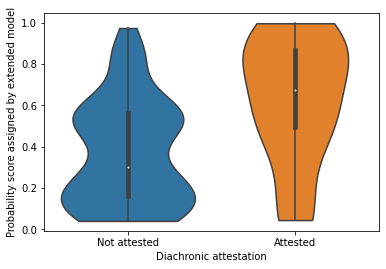

In [22]:
# Violin plot illustrating distribution of the data in the attested and unattested groups.
violin = sns.violinplot(cut=0, x="Attested", y="Probability_score", data=combined_model_table)
violin.set_ylabel('Probability score assigned by extended model')
violin.set_xlabel('Diachronic attestation')
violin.set_xticklabels(['Not attested','Attested'])

In [23]:
# Sample sizes for attested and unattested group (Table 14)
combined_model_table.groupby('Attested').count()

,Form,Target_cell,Destination_class,Number_of_proportions,Probability_score
Attested,,,,,
0,84,84,84,84,84
1,22,22,22,22,22


In [24]:
# Means for attested and unattested group (Table 14)
combined_model_table.groupby('Attested').mean()

,Number_of_proportions,Probability_score
Attested,,
0,2.202381,0.368320
1,2.909091,0.625425


In [25]:
# Medians for attested and unattested group (Table 14)
combined_model_table.groupby('Attested').median()

,Number_of_proportions,Probability_score
Attested,,
0,1.5,0.299309
1,2.0,0.674595
